#Hidden Layer

In [1]:
#!pip install hiddenlayer

#import hiddenlayer as hl

#Importar Librerias

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from PIL import Image

from glob import glob

#Para usar GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Funcion auxiliar para la matrix de confusion 

In [44]:
def CM(Y_true, Y_pred, classes: int):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()  

#Preparar el Dataset

In [ ]:
!unzip fashion-mnist.zip

In [5]:
train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)
len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [6]:
X_train, X_valid, X_test = [], [], []
Y_train, Y_valid, Y_test = [], [], []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))
for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append(np.array(Image.open(valid_file)))
for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append(np.array(Image.open(test_file)))

##Visualizar los datos

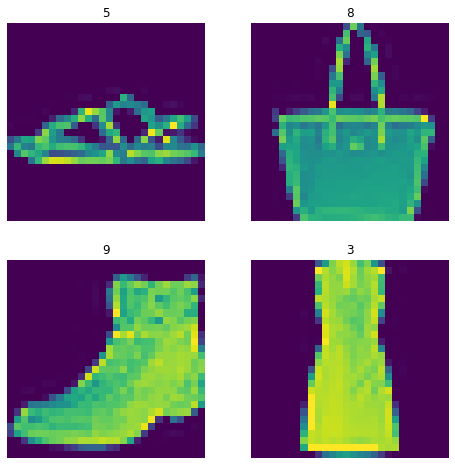

In [7]:
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [8]:
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

In [13]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

1719

#Crear el modelo

##Utilizando modelo CNN con dos capas convolucionales y dos capas Global Average Pooling 
La primera es una capa convolucional con 14 kernels, cada kernel de 9x9, stride=1 y padding=2. Utiliza una funcion de activacion tipo relu.

La segunda es una capa Global Average Pooling e implementa Dropout al 20%.

La tercera es otra capa convolucional con 28 kernels, cada kernel de 5x5, stride=1 y padding=1. Utiliza una funcion de activacion tipo relu.

La cuarta es otra capa Global Average Pooling y Dropout al 20%.


In [32]:
model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 14, kernel_size=9, stride=1, padding=2),
  #out: ( (28-7+2*2)/1 ) + 1 = 24   -> 24 x 24 x 14

  torch.nn.ReLU(),

  torch.nn.AvgPool2d(kernel_size=2),
  #out: 24/2 = 12                 -> 12 x 12 x 14

  torch.nn.Dropout(p=0.2), 

  torch.nn.Conv2d(14, 28, kernel_size=5, stride=1, padding=1),
  #out: ( (12-5+2*1)/1 ) + 1 = 10   -> 10 x 10 x 28

  torch.nn.ReLU(),

  torch.nn.AvgPool2d(kernel_size=2),
  #out: 10/2 = 5                 -> 5 x 5 x 28

  torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(5*5*28, 10)
)
model

Sequential(
  (0): Conv2d(1, 14, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(14, 28, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=700, out_features=10, bias=True)
)

In [33]:
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

In [34]:
#hl.build_graph(model, torch.zeros([28,1,2,2]))

#Entrenar el modelo

In [35]:
loss_list = []
f1_list = []
acc_list = []
n_epoch = 10
pbar = tqdm(total=n_epoch*len(train_dl))
iter=0
for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)
    
    Y_pred = torch.argmax(Y_pred, 1)

    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')
    
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    
    if iter%10 == 0:
      loss_list.append(loss)
      f1_list.append(f1)
      acc_list.append(acc)
    iter+=1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.update()
pbar.close()

  0%|          | 0/17190 [00:00<?, ?it/s]

##Visualizar mapas de características de la segunda capa

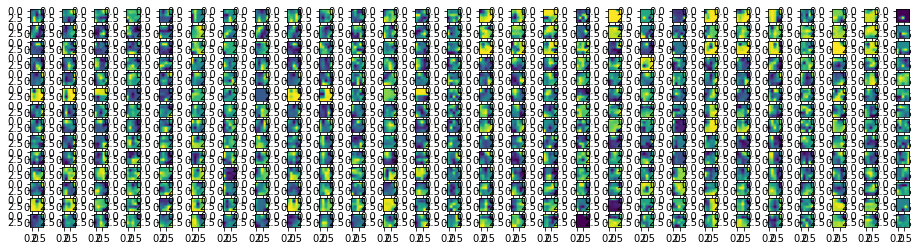

In [72]:
kernels = list(model.children())[4].weight.detach().cpu()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels.size(0)):
  for j in range(14):
      plt.subplot(14,28,k+1)
      plt.imshow(kernels[i].squeeze()[j])
      k += 1
plt.show()

#Graficar los Scores

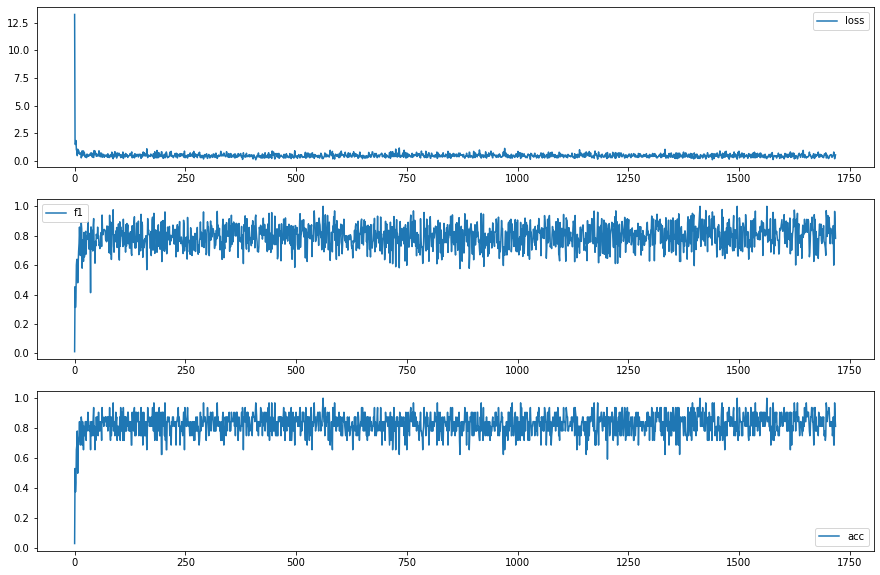

In [41]:
fig = plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(loss_list, label='loss')
plt.legend()
plt.subplot(3,1,2)
plt.plot(f1_list, label='f1')
plt.legend()
plt.subplot(3,1,3)
plt.plot(acc_list, label='acc')
plt.legend()

#Evaluar el modelo

In [47]:
X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
model.eval()
Xvl = X_valid.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.45, F1:0.84, Acc:0.84


##Matrix de Confusion

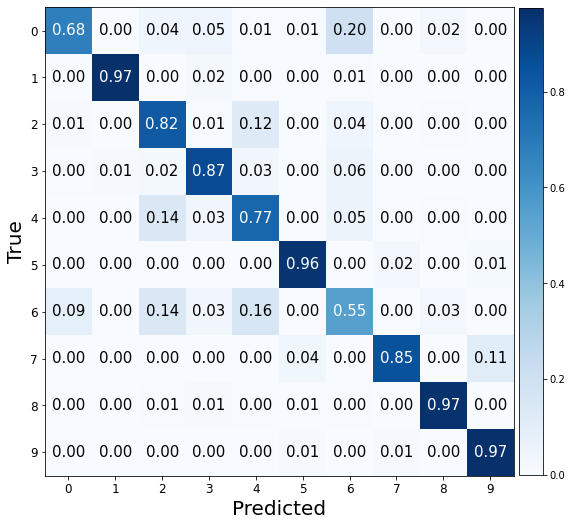

In [48]:
CM(Y_valid.cpu(), Y_pred.cpu(), 10)

#Conclusiones
El modelo es bastante bueno mostrando una covergencia en los valores de score durante las primeras etapas del entrenamiento. Ademas optiene una capacidad de prediccion de hasta el 97% de varias categorias. 